In [62]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import geometry
import shapely.speedups
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.cluster import KMeans
from quetzal.model import stepmodel

# Preparation of input data
## Generates a DataFrame of PT stops with mean weighted distances to population cells
## Needs all PT nodes

In [2]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../input_static/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network')

In [4]:
# Map nodes to zones
if 'FID' not in sm.nodes.columns:
    shapely.speedups.enable()
    sm.nodes['FID'] = np.nan
    sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    sm.nodes.to_file(model_path + 'de_pt_network/nodes.geojson', driver='GeoJSON', encoding='utf-8')

In [5]:
bus = stepmodel.read_json(model_path + 'de_pt_network_bus')

In [6]:
# Map bus nodes to zones
if 'FID' not in bus.nodes.columns:
    shapely.speedups.enable()
    bus.nodes['FID'] = np.nan
    bus.nodes = gpd.GeoDataFrame(bus.nodes, crs=sm.epsg)
    for _, zone in tqdm(bus.zones.iterrows(), total=bus.zones.shape[0]):
        bus.nodes.loc[bus.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    bus.nodes.to_file(model_path + 'de_pt_network_bus/nodes.geojson', driver='GeoJSON', encoding='utf-8')

In [7]:
# Merge
sm.nodes = sm.nodes.append(bus.nodes)

## Use census data
The important question for mode choice problems: How long/inconvenient is it from home to the next PT stop? </br>
Approach: Build population densities from census data and calculate the mean weighted distance to the next PT stop.

In [8]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)

In [9]:
print(pop.shape)
pop.head(2)

(3177723, 4)


,Einwohner,NUTS_ID,FID,geometry
0,8,DE27E,DE27E,POINT (10.21212 47.31574)
1,7,DE27E,DE27E,POINT (10.26631 47.31562)


In [10]:
pop_r = pop

In [11]:
# Restrict to a geometric hull
#sm.zones = gpd.GeoDataFrame(sm.zones)
#hull = sm.zones["geometry"].buffer(1e-3).unary_union
# Restrict to the geometric hull if the latter is not Germany
#pop_r = pop.loc[pop['geometry'].apply(lambda p: p.within(hull))]
#print(pop_r.shape)

In [17]:
# Map to zones
if 'FID' not in pop_r.columns:
    shapely.speedups.enable()
    zones = gpd.GeoDataFrame(sm.zones.sort_values('area', ascending=False), crs=sm.epsg)
    #centr['geometry'] = zones['geometry'].centroid
    pop_r['FID'] = np.nan
    for _, zone in tqdm(zones.iterrows(), total=sm.zones.shape[0]):
        geo = zone['geometry'].buffer(0.08)
        pop_r.loc[pop_r['geometry'].within(geo), 'FID'] = zone['FID']
    pop_r.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

100%|██████████████████████████████████████████████████████████████████████████████| 467/467 [2:06:46<00:00, 16.29s/it]


In [18]:
pop_r.loc[pop_r['FID'].isna()]

,Einwohner,NUTS_ID,FID,geometry
3145216,3,DEF07,NaN,POINT (8.55149 54.46235)
3148407,3,DEF07,NaN,POINT (8.65072 54.49313)
3148408,3,DEF07,NaN,POINT (8.65226 54.49314)
3148654,3,DEF07,NaN,POINT (8.63369 54.49474)
3148770,5,DEF07,NaN,POINT (8.65989 54.49592)
...,...,...,...,...
3167797,4,DEF07,NaN,POINT (8.55860 54.74465)
3167861,5,DEF07,NaN,POINT (8.55702 54.74553)
3167917,6,DEF07,NaN,POINT (8.52595 54.74606)
3167918,3,DEF07,NaN,POINT (8.55233 54.74637)


<AxesSubplot:>

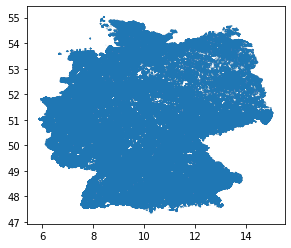

In [19]:
# Visualise
#zones_plot = sm.plot('zones', alpha=0.1, figsize=[16, 9], color='green')
pop_r.plot(markersize=list(pop_r['Einwohner']/300), alpha=0.2)#, ax=zones_plot)

### Apply K-Means to find weighted distances of PT stops

In [20]:
sm.nodes.shape

(429079, 4)

In [21]:
# Settings:
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
pop_col = 'population'
max_iter_per_group = 10

In [60]:
errors = []
def weighted_dist(zone):
    nuts_id = zone['FID'].unique()[0]
    # Get the population points
    pop_p = pop_r.loc[pop_r['FID']==nuts_id]
    # Count the number of PT stops in the zone and make it the number of clusters
    n_clusters = len(zone.index)
    if n_clusters > 0:
        # Prepare sample
        X = np.array([[p.x, p.y] for p in list(pop_p['geometry'])])
        # Prepare initial starting points
        nodes_coords = np.array([[p.x, p.y] for p in list(zone['geometry'])])
        # Apply weighted K-Means
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=0,
                        init=nodes_coords,
                        max_iter=max_iter_per_group)
        try:
            kmeans.fit(X, sample_weight=np.array(list(pop_p['Einwohner'])))
        except ValueError: # More stations than samples
            zone[cent_col] = zone['geometry']
            zone[pop_col] = pop_p['Einwohner'].sum() / n_clusters
            zone[dist_col] = 100
            zone[mean_dist_col] = 100
            return zone
        # Create results DataFrame
        zone[cent_col] = [geometry.Point(c[0], c[1]) for c in kmeans.cluster_centers_]
        # Add population to calculate the mean weighted distance for each zone later
        pop_p['cluster'] = list(kmeans.labels_)
        #    kmeans.predict(X, sample_weight=np.array(list(pop_p['Einwohner']))))
        try:
            zone[pop_col] = list(pop_p.groupby('cluster').agg({'Einwohner': 'sum'})['Einwohner'])
        except ValueError: # Fewer labels than n_clusters
            zone[pop_col] = pop_p['Einwohner'].mean()
            errors.append((nuts_id, zone['route_type'].unique()[0]))
        # Calculate distance between centroid and PT node
        zone[dist_col] = [geodesic(kmeans.cluster_centers_[i], nodes_coords[i]).m
                          for i in range(n_clusters)]
        # Add mean weighted distance
        zone[mean_dist_col] = (zone[pop_col]*zone[dist_col]).sum() / zone[pop_col].sum()
        return zone
    else:
        return

In [63]:
# Generate clusters for every route type
tqdm.pandas()
clusters = sm.nodes.groupby(['route_type', 'FID']).progress_apply(weighted_dist)












  0%|                                                                                         | 0/1395 [00:00<?, ?it/s]










  0%|                                                                                 | 1/1395 [00:00<12:31,  1.85it/s]










  0%|                                                                                 | 2/1395 [00:00<11:46,  1.97it/s]










  0%|▏                                                                                | 3/1395 [00:01<10:03,  2.31it/s]










  0%|▏                                                                                | 4/1395 [00:01<10:16,  2.26it/s]










  0%|▎                                                                                | 5/1395 [00:01<08:52,  2.61it/s]










  0%|▎                                                                                | 6/1395 [00:02<07:44,  2.99it/s]










  1%|▍                                                                         

  7%|█████▋                                                                         | 100/1395 [02:27<24:30,  1.14s/it]










  7%|█████▋                                                                         | 101/1395 [02:29<28:00,  1.30s/it]










  7%|█████▊                                                                         | 102/1395 [02:30<31:34,  1.47s/it]










  7%|█████▊                                                                         | 103/1395 [02:31<28:43,  1.33s/it]










  7%|█████▉                                                                         | 104/1395 [02:33<27:52,  1.30s/it]










  8%|█████▉                                                                         | 105/1395 [02:33<22:57,  1.07s/it]










  8%|██████                                                                         | 106/1395 [02:37<41:28,  1.93s/it]










  8%|██████                                                                         | 107/

 14%|███████████                                                                  | 200/1395 [05:26<1:00:16,  3.03s/it]










 14%|███████████                                                                  | 201/1395 [05:30<1:03:27,  3.19s/it]










 14%|███████████▍                                                                   | 202/1395 [05:32<59:23,  2.99s/it]










 15%|███████████▍                                                                   | 203/1395 [05:35<56:05,  2.82s/it]










 15%|███████████▌                                                                   | 204/1395 [05:38<59:01,  2.97s/it]










 15%|███████████▌                                                                   | 205/1395 [05:40<51:17,  2.59s/it]










 15%|███████████▋                                                                   | 206/1395 [05:42<51:30,  2.60s/it]










 15%|███████████▋                                                                   | 207/

 22%|████████████████▉                                                              | 300/1395 [10:02<47:42,  2.61s/it]










 22%|█████████████████                                                              | 301/1395 [10:04<45:48,  2.51s/it]










 22%|█████████████████                                                              | 302/1395 [10:08<50:46,  2.79s/it]










 22%|████████████████▋                                                            | 303/1395 [10:14<1:06:42,  3.66s/it]










 22%|████████████████▊                                                            | 304/1395 [10:16<1:01:06,  3.36s/it]










 22%|████████████████▊                                                            | 305/1395 [10:25<1:31:40,  5.05s/it]










 22%|████████████████▉                                                            | 306/1395 [10:29<1:25:46,  4.73s/it]










 22%|████████████████▉                                                            | 307/13

 29%|██████████████████████▋                                                        | 400/1395 [14:45<08:00,  2.07it/s]










 29%|██████████████████████▋                                                        | 401/1395 [14:46<07:36,  2.18it/s]










 29%|██████████████████████▊                                                        | 402/1395 [14:46<08:45,  1.89it/s]










 29%|██████████████████████▊                                                        | 403/1395 [14:47<08:02,  2.06it/s]










 29%|██████████████████████▉                                                        | 404/1395 [14:47<07:09,  2.31it/s]










 29%|██████████████████████▉                                                        | 405/1395 [14:47<06:56,  2.38it/s]










 29%|██████████████████████▉                                                        | 406/1395 [14:48<09:45,  1.69it/s]










 29%|███████████████████████                                                        | 407/

 36%|████████████████████████████▎                                                  | 500/1395 [18:04<06:20,  2.35it/s]










 36%|████████████████████████████▎                                                  | 501/1395 [18:05<06:24,  2.32it/s]










 36%|████████████████████████████▍                                                  | 502/1395 [18:05<06:52,  2.17it/s]










 36%|████████████████████████████▍                                                  | 503/1395 [18:06<06:52,  2.16it/s]










 36%|████████████████████████████▌                                                  | 504/1395 [18:06<05:54,  2.51it/s]










 36%|████████████████████████████▌                                                  | 505/1395 [18:06<05:21,  2.77it/s]










 36%|████████████████████████████▋                                                  | 506/1395 [18:07<05:13,  2.83it/s]










 36%|████████████████████████████▋                                                  | 507/

 43%|█████████████████████████████████▉                                             | 600/1395 [18:46<05:17,  2.51it/s]










 43%|██████████████████████████████████                                             | 601/1395 [18:47<04:51,  2.72it/s]










 43%|██████████████████████████████████                                             | 602/1395 [18:47<05:22,  2.46it/s]










 43%|██████████████████████████████████▏                                            | 603/1395 [18:48<04:52,  2.71it/s]










 43%|██████████████████████████████████▏                                            | 604/1395 [18:48<04:58,  2.65it/s]










 43%|██████████████████████████████████▎                                            | 605/1395 [18:48<04:40,  2.81it/s]










 43%|██████████████████████████████████▎                                            | 606/1395 [18:48<04:13,  3.11it/s]










 44%|██████████████████████████████████▎                                            | 607/

 50%|███████████████████████████████████████▋                                       | 700/1395 [19:36<04:24,  2.63it/s]










 50%|███████████████████████████████████████▋                                       | 701/1395 [19:36<04:16,  2.70it/s]










 50%|███████████████████████████████████████▊                                       | 702/1395 [19:36<04:04,  2.83it/s]










 50%|███████████████████████████████████████▊                                       | 703/1395 [19:37<04:20,  2.66it/s]










 50%|███████████████████████████████████████▊                                       | 704/1395 [19:37<04:42,  2.44it/s]










 51%|███████████████████████████████████████▉                                       | 705/1395 [19:38<04:33,  2.52it/s]










 51%|███████████████████████████████████████▉                                       | 706/1395 [19:38<04:52,  2.36it/s]










 51%|████████████████████████████████████████                                       | 707/

 57%|█████████████████████████████████████████████▎                                 | 800/1395 [20:13<03:40,  2.70it/s]










 57%|█████████████████████████████████████████████▎                                 | 801/1395 [20:13<03:54,  2.53it/s]










 57%|█████████████████████████████████████████████▍                                 | 802/1395 [20:14<03:41,  2.67it/s]










 58%|█████████████████████████████████████████████▍                                 | 803/1395 [20:14<04:31,  2.18it/s]










 58%|█████████████████████████████████████████████▌                                 | 804/1395 [20:16<06:37,  1.49it/s]










 58%|█████████████████████████████████████████████▌                                 | 805/1395 [20:16<05:49,  1.69it/s]










 58%|█████████████████████████████████████████████▋                                 | 806/1395 [20:16<04:53,  2.01it/s]










 58%|█████████████████████████████████████████████▋                                 | 807/

 65%|██████████████████████████████████████████████████▉                            | 900/1395 [20:54<02:35,  3.19it/s]










 65%|███████████████████████████████████████████████████                            | 901/1395 [20:55<03:36,  2.28it/s]










 65%|███████████████████████████████████████████████████                            | 902/1395 [20:56<03:42,  2.22it/s]










 65%|███████████████████████████████████████████████████▏                           | 903/1395 [20:56<03:33,  2.30it/s]










 65%|███████████████████████████████████████████████████▏                           | 904/1395 [20:57<03:54,  2.09it/s]










 65%|███████████████████████████████████████████████████▎                           | 905/1395 [20:57<03:24,  2.40it/s]










 65%|███████████████████████████████████████████████████▎                           | 906/1395 [20:57<03:12,  2.54it/s]










 65%|███████████████████████████████████████████████████▎                           | 907/

 72%|███████████████████████████████████████████████████████▉                      | 1000/1395 [21:34<02:25,  2.72it/s]










 72%|███████████████████████████████████████████████████████▉                      | 1001/1395 [21:35<02:19,  2.82it/s]










 72%|████████████████████████████████████████████████████████                      | 1002/1395 [21:35<02:23,  2.73it/s]










 72%|████████████████████████████████████████████████████████                      | 1003/1395 [21:36<02:30,  2.61it/s]










 72%|████████████████████████████████████████████████████████▏                     | 1004/1395 [21:36<03:04,  2.11it/s]










 72%|████████████████████████████████████████████████████████▏                     | 1005/1395 [21:37<02:54,  2.24it/s]










 72%|████████████████████████████████████████████████████████▏                     | 1006/1395 [21:37<02:45,  2.35it/s]










 72%|████████████████████████████████████████████████████████▎                     | 1007/

 79%|█████████████████████████████████████████████████████████████▌                | 1100/1395 [22:11<04:22,  1.12it/s]










 79%|█████████████████████████████████████████████████████████████▌                | 1101/1395 [22:11<03:32,  1.38it/s]










 79%|█████████████████████████████████████████████████████████████▌                | 1102/1395 [22:11<02:53,  1.69it/s]










 79%|█████████████████████████████████████████████████████████████▋                | 1103/1395 [22:12<02:56,  1.66it/s]










 79%|█████████████████████████████████████████████████████████████▋                | 1104/1395 [22:13<02:51,  1.70it/s]










 79%|█████████████████████████████████████████████████████████████▊                | 1105/1395 [22:13<02:21,  2.06it/s]










 79%|█████████████████████████████████████████████████████████████▊                | 1106/1395 [22:13<02:11,  2.20it/s]










 79%|█████████████████████████████████████████████████████████████▉                | 1107/

 86%|███████████████████████████████████████████████████████████████████           | 1200/1395 [22:52<01:20,  2.42it/s]










 86%|███████████████████████████████████████████████████████████████████▏          | 1201/1395 [22:53<01:28,  2.18it/s]










 86%|███████████████████████████████████████████████████████████████████▏          | 1202/1395 [22:53<01:19,  2.43it/s]










 86%|███████████████████████████████████████████████████████████████████▎          | 1203/1395 [22:54<01:20,  2.39it/s]










 86%|███████████████████████████████████████████████████████████████████▎          | 1204/1395 [22:54<01:15,  2.52it/s]










 86%|███████████████████████████████████████████████████████████████████▍          | 1205/1395 [22:54<01:08,  2.78it/s]










 86%|███████████████████████████████████████████████████████████████████▍          | 1206/1395 [22:55<01:10,  2.69it/s]










 87%|███████████████████████████████████████████████████████████████████▍          | 1207/

 93%|████████████████████████████████████████████████████████████████████████▋     | 1300/1395 [23:38<00:32,  2.91it/s]










 93%|████████████████████████████████████████████████████████████████████████▋     | 1301/1395 [23:38<00:31,  3.00it/s]










 93%|████████████████████████████████████████████████████████████████████████▊     | 1302/1395 [23:39<00:29,  3.11it/s]










 93%|████████████████████████████████████████████████████████████████████████▊     | 1303/1395 [23:39<00:27,  3.39it/s]










 93%|████████████████████████████████████████████████████████████████████████▉     | 1304/1395 [23:39<00:25,  3.51it/s]










 94%|████████████████████████████████████████████████████████████████████████▉     | 1305/1395 [23:39<00:23,  3.77it/s]










 94%|█████████████████████████████████████████████████████████████████████████     | 1306/1395 [23:40<00:22,  3.94it/s]










 94%|█████████████████████████████████████████████████████████████████████████     | 1307/

In [64]:
errors

[('DE111', 'bus'),
 ('DE112', 'bus'),
 ('DE113', 'bus'),
 ('DE114', 'bus'),
 ('DE115', 'bus'),
 ('DE116', 'bus'),
 ('DE117', 'bus'),
 ('DE118_1', 'bus'),
 ('DE118_2', 'bus'),
 ('DE119', 'bus'),
 ('DE11A', 'bus'),
 ('DE11B', 'bus'),
 ('DE11C', 'bus'),
 ('DE11D', 'bus'),
 ('DE123_3', 'bus'),
 ('DE124_2', 'bus'),
 ('DE124_3', 'bus'),
 ('DE125', 'bus'),
 ('DE126', 'bus'),
 ('DE127', 'bus'),
 ('DE128_1', 'bus'),
 ('DE128_2', 'bus'),
 ('DE128_3', 'bus'),
 ('DE12A', 'bus'),
 ('DE12B_1', 'bus'),
 ('DE12C', 'bus'),
 ('DE132_1', 'bus'),
 ('DE132_2', 'bus'),
 ('DE133', 'bus'),
 ('DE134', 'bus'),
 ('DE135', 'bus'),
 ('DE136', 'bus'),
 ('DE138', 'bus'),
 ('DE139', 'bus'),
 ('DE13A', 'bus'),
 ('DE141', 'bus'),
 ('DE142', 'bus'),
 ('DE143', 'bus'),
 ('DE144', 'bus'),
 ('DE145_1', 'bus'),
 ('DE145_2', 'bus'),
 ('DE146', 'bus'),
 ('DE147', 'bus'),
 ('DE148', 'bus'),
 ('DE149', 'bus'),
 ('DE211', 'bus'),
 ('DE212', 'bus'),
 ('DE215', 'bus'),
 ('DE216', 'bus'),
 ('DE217', 'bus'),
 ('DE218', 'bus'),
 ('DE

In [65]:
clusters.sample(4)

,FID,geometry,route_type,stop_name,cluster_center,population,weighted_dist,mean_weighted_dist
index,,,,,,,,
bus_n_284743,DED21,POINT (13.81727 50.99828),bus,Dresden Mühlenstraße,POINT (13.81828196212793 50.99875523605947),273.000000,122.650948,2580.842670
bus_n_291287,DE26C_1,POINT (9.97946 49.62529),bus,Wolkshausen Ort,POINT (9.979404727285303 49.62506989839392),20.500210,25.460207,22491.343219
bus_n_31627,DED45,POINT (12.41519 50.74848),bus,"Königswalde, Schule",POINT (12.41452738572492 50.7489024177109),22.670262,86.338425,19828.796660
bus_n_232916,DEE0B_2,POINT (11.78289 51.47018),bus,"Teutschenthal Bhf, Schule 1",POINT (11.78140808745395 51.47061710439908),14.450744,171.243232,24523.810121


route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

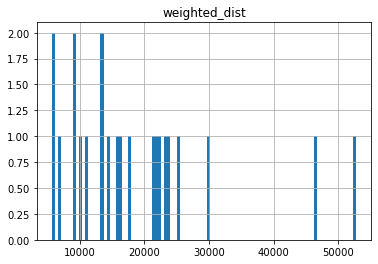

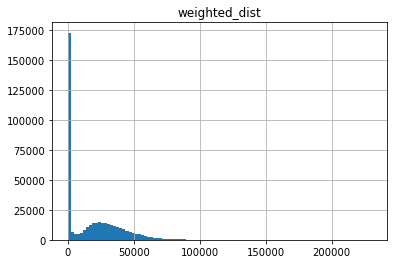

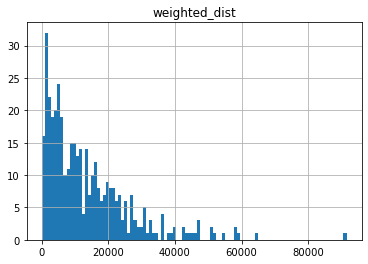

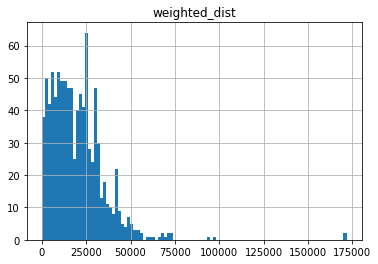

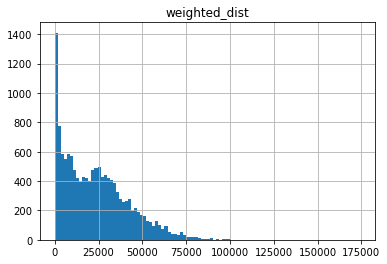

In [66]:
clusters.groupby('route_type').hist(column=dist_col, bins=100)

route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

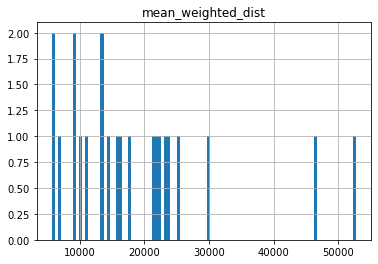

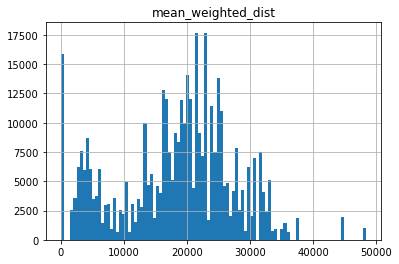

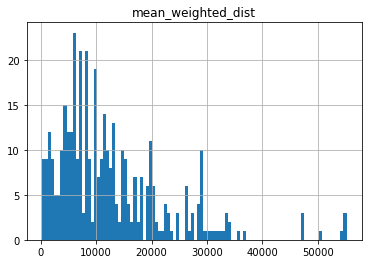

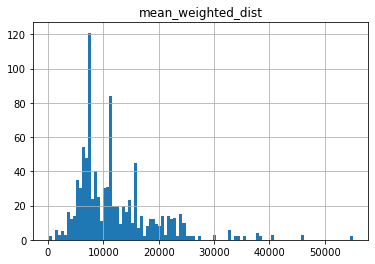

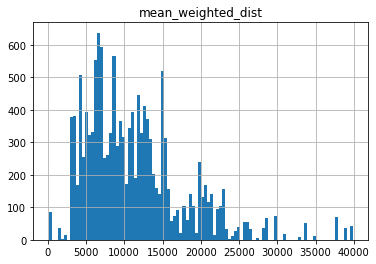

In [67]:
clusters.groupby('route_type').hist(column=mean_dist_col, bins=100)

In [68]:
# Save the population centroids
clusters.to_csv('../input/spatial_census_refined_FID.csv')